# 0.&nbsp;Copyright

This notebook is used as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.
The goal is that you try the basics of text-to-speech synthesis (TTS) in practice, i.e. how deep learning models are used within TTS.

Originally, it is from NVIDIA (NeMo toolkit), with a few minor modifications.

Source: https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/NeMo_TTS_Primer.ipynb


2025 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)

# 1.&nbsp;Setup

In [93]:
# this will take a few minutes to install, so start doing it, and after that, you can start reading Chapter 2.

# Install NeMo library.
BRANCH = 'r1.21.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

# Install nemo_text_processing package (required for text normalization)
# This is a separate package from nemo_toolkit
!python -m pip install nemo_text_processing

10114.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


zsh:1: no matches found: git+https://github.com/NVIDIA/NeMo.git@r1.21.0#egg=nemo_toolkit[all]


10119.80s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached nemo_text_processing-1.1.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached pynini-2.1.6.post1.tar.gz (790 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached nemo_text_processing-1.1.0-py3-none-any.whl (2.7 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for pynini (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [183 lines of output]
      /private/var/folders/1f/mqpzkd3x1yz5jjxkrsrc28cc0000gn/T/pip-build-env-r8xg8fqz/overlay/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options availa

In [94]:
# Download local version of NeMo scripts. If you are running locally and want to use your own local NeMo code,
# comment out the below lines and set NEMO_DIR to your local path.
NEMO_DIR = 'nemo'
!git clone https://github.com/NVIDIA/NeMo.git $NEMO_DIR

10132.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fatal: destination path 'nemo' already exists and is not an empty directory.


# 2.&nbsp;Introduction to TTS

This notebook provides a high level overview of text-to-speech (TTS). It will cover high level concepts and discuss each component in a standard TTS pipeline, providing relevant examples and code snippets using [NeMo](https://github.com/NVIDIA/NeMo).

# 3.&nbsp;What is TTS?

**Text-to-speech**, also known as **TTS** or **speech synthesis**, refers to a system by which a computer reads text aloud. Typically the synthesized audio resembles a realistic human voice.

Most TTS models sound like the voice of the speaker whose audio it is trained on. Though some more recently developed algorithms have the potential to sound like real speakers they were not trained on, or sound like entirely new voices.


# 4.&nbsp;The TTS pipeline

Modern TTS systems are fairly complex, with an end to end pipeline consisting of several components that each require their own model or heuristics.

A standard pipeline might look like:

1.   **Text Normalization**: Converting raw text to spoken text (eg. "Mr." &rarr; "mister").<br>
2.   **Grapheme to Phoneme conversion (G2P)**: Convert basic units of text (ie. graphemes/characters) to basic units of spoken language (ie. phonemes).
3.   **Spectrogram Synthesis**: Convert text/phonemes into a spectrogram.
4.   **Audio Synthesis**: Convert spectrogram into audio. Also known as **spectrogram inversion**. Models which do this are called **vocoders**.

While this is the most common structure, there may be fewer or additional steps depending on the use case. For example, some languages do not require G2P and can instead rely on the model to convert raw text/graphemes to spectrogram.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tts_pipeline.png" width="500", height="500"/>
</div>

# 5.&nbsp;Text Normalization (TN)

The first step is to pre-process the raw input text into a standardized form. Some examples of processing steps could include:

<table>
  <tr>
    <th>Normalization Type</th>
    <th>Input</th>
    <th>Output</th>
  </tr>
  <tr>
    <td>Abbreviations</td>
    <td>Mr.</td>
    <td>mister<td>
  </tr>
  <tr>
    <td>Acronyms</td>
    <td>TTS</td>
    <td>text to speech<td>
  </tr>
  <tr>
    <td>Numbers</td>
    <td>42</td>
    <td>forty two</td>
  </tr>
  <tr>
    <td>Decimals</td>
    <td>1.2</td>
    <td>one point two</td>
  </tr>
  <tr>
    <td>Roman Numerals</td>
    <td>VII</td>
    <td>seventh</td>
  </tr>
  <tr>
    <td>Cardinal Directions</td>
    <td>N E S W</td>
    <td>north east south west</td>
  </tr>
  <tr>
    <td>URL</td>
    <td>www.github.com</td>
    <td>w w w dot github dot com</td>
  </tr>
</table>

The above examples may be slightly different than the output of the NeMo text normalization code. More details on NeMo text normalization can be found in the [TN documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/nlp/text_normalization/intro.html).

A more comprehensive list of text normalization rules, examples, and languages are available in the [code](https://github.com/NVIDIA/NeMo-text-processing/tree/main/nemo_text_processing/text_normalization).



## 5.1&nbsp;TN example

After installing NeMo, we can do text normalization with just a few lines of code.

In [ ]:
try:
    from nemo_text_processing.text_normalization.normalize import Normalizer
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "The package `nemo_text_processing` was not installed in this environment. Please refer to"
        " https://github.com/NVIDIA/NeMo-text-processing and install this package before using "
        "this script"
    )

text_normalizer = Normalizer(input_case="cased", lang="en")

ModuleNotFoundError: The package `nemo_text_processing` was not installed in this environment. Please refer to https://github.com/NVIDIA/NeMo-text-processing and install this package before using this script

In [95]:
# IMPORTANT: Install nemo_text_processing package
# This is a SEPARATE package from nemo_toolkit and must be installed separately

# Check if already installed
try:
    import nemo_text_processing
    print("✓ nemo_text_processing is already installed!")
except ImportError:
    print("=" * 70)
    print("Installing nemo_text_processing...")
    print("=" * 70)
    print("\nNOTE: This package requires pynini, which may need system dependencies.")
    print("If installation fails, see the troubleshooting section below.\n")
    
    # Try to install
    !pip install nemo_text_processing
    
    # Verify installation
    try:
        import nemo_text_processing
        print("\n✓ nemo_text_processing installed successfully!")
    except ImportError:
        print("\n" + "=" * 70)
        print("INSTALLATION FAILED - Troubleshooting Guide")
        print("=" * 70)
        print("\nThe error is likely due to pynini compilation issues.")
        print("\nSOLUTION 1 (Recommended for macOS with Homebrew):")
        print("  1. Open Terminal and run: brew install openfst")
        print("  2. Then run this cell again")
        print("\nSOLUTION 2 (If using conda):")
        print("  1. In Terminal, run: conda install -c conda-forge pynini")
        print("  2. Then run: pip install nemo_text_processing")
        print("\nSOLUTION 3 (Skip text normalization for now):")
        print("  You can continue with other parts of the notebook.")
        print("  Text normalization is optional for basic TTS tasks.")
        print("\nFor more help: https://github.com/NVIDIA/NeMo-text-processing")
        print("=" * 70)

Installing nemo_text_processing...

NOTE: This package requires pynini, which may need system dependencies.
If installation fails, see the troubleshooting section below.



10137.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached nemo_text_processing-1.1.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached pynini-2.1.6.post1.tar.gz (790 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached nemo_text_processing-1.1.0-py3-none-any.whl (2.7 MB)
  error: subprocess-exited-with-error
  
  × Building wheel for pynini (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [183 lines of output]
      /private/var/folders/1f/mqpzkd3x1yz5jjxkrsrc28cc0000gn/T/pip-build-env-xtqopyhv/overlay/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options availa

In [ ]:
# Install nemo_text_processing package if not already installed
# Uncomment the line below if you get ModuleNotFoundError
# !pip install nemo_text_processing

In [96]:
# Check if text_normalizer is available before using it
if 'text_normalizer' not in globals():
    print("=" * 70)
    print("ERROR: text_normalizer is not defined!")
    print("=" * 70)
    print("\nPlease run the previous cell (5.1 TN example) first to initialize text_normalizer.")
    print("If you get an error about 'nemo_text_processing', you need to:")
    print("  1. Install it: !pip install nemo_text_processing")
    print("  2. Or install system dependencies first (macOS): brew install openfst")
    print("=" * 70)
else:
    text = "Mr. Johnson is turning 35 years old on 04-15-2023."
    normalized_text = text_normalizer.normalize(text)
    
    print(text)
    print(normalized_text)

ERROR: text_normalizer is not defined!

Please run the previous cell (5.1 TN example) first to initialize text_normalizer.
If you get an error about 'nemo_text_processing', you need to:
  1. Install it: !pip install nemo_text_processing
  2. Or install system dependencies first (macOS): brew install openfst


In [ ]:
### YOUR TASK: test text normalization with several other examples.
# add a sentence with common abbreviations, like 'etc.', 'e.g.', 'ASAP', 'RSVP', ...
# extend the sentence with dates in various formats (e.g. month with numbers / abbreviated)
# extend the sentence with numbers including decimals
# extend the sentence with special characters, like €, $, @,
# ---> and see, which of these are noramlized well. did you find any issues in the text normalization part?

In [97]:
# Test text normalization with various examples
# First, check if text_normalizer is available
if 'text_normalizer' not in globals():
    print("=" * 70)
    print("Warning: text_normalizer is not available")
    print("=" * 70)
    print("\nPlease run the previous cell (Section 5.1 TN example) first to initialize text_normalizer.")
    print("If you get an error about 'nemo_text_processing', you need to install it:")
    print("  !pip install nemo_text_processing")
    print("\nFor now, we'll show what the tests would look like:")
    print("=" * 70)
    
    # Show what would be tested
    test_cases = [
        ("Common Abbreviations", "Please RSVP ASAP, e.g., by email, etc."),
        ("Dates in Various Formats", "The meeting is on 12/25/2023, Jan 15, 2024, and 2024-03-20."),
        ("Numbers and Decimals", "The price is $99.99, temperature is 36.5 degrees, and we have 3.14159."),
        ("Special Characters", "Contact us at info@example.com or visit www.example.com. Price: €50, $100, or ¥1000."),
        ("Combined Complex Example", "Dr. Smith, etc., will meet on 12/31/2023 at 3:30 PM. Price: $199.99 or €180. Contact: info@company.com, ASAP!")
    ]
    
    for i, (test_name, test_text) in enumerate(test_cases, 1):
        print(f"\nTest {i}: {test_name}")
        print(f"Original:  {test_text}")
        print("Normalized: [Would be processed by text_normalizer]")
    
    print("\n" + "=" * 70)
    print("Please install nemo_text_processing and run the previous cell first!")
    print("=" * 70)
else:
    print("=" * 70)
    print("Testing Text Normalization with Various Examples")
    print("=" * 70)

    # Test 1: Common abbreviations
    print("\n" + "=" * 70)
    print("Test 1: Common Abbreviations")
    print("=" * 70)
    test1 = "Please RSVP ASAP, e.g., by email, etc."
    normalized1 = text_normalizer.normalize(test1)
    print(f"Original:  {test1}")
    print(f"Normalized: {normalized1}")

    # Test 2: Dates in various formats
    print("\n" + "=" * 70)
    print("Test 2: Dates in Various Formats")
    print("=" * 70)
    test2 = "The meeting is on 12/25/2023, Jan 15, 2024, and 2024-03-20."
    normalized2 = text_normalizer.normalize(test2)
    print(f"Original:  {test2}")
    print(f"Normalized: {normalized2}")

    # Test 3: Numbers including decimals
    print("\n" + "=" * 70)
    print("Test 3: Numbers and Decimals")
    print("=" * 70)
    test3 = "The price is $99.99, temperature is 36.5 degrees, and we have 3.14159."
    normalized3 = text_normalizer.normalize(test3)
    print(f"Original:  {test3}")
    print(f"Normalized: {normalized3}")

    # Test 4: Special characters
    print("\n" + "=" * 70)
    print("Test 4: Special Characters")
    print("=" * 70)
    test4 = "Contact us at info@example.com or visit www.example.com. Price: €50, $100, or ¥1000."
    normalized4 = text_normalizer.normalize(test4)
    print(f"Original:  {test4}")
    print(f"Normalized: {normalized4}")

    # Test 5: Combined complex example
    print("\n" + "=" * 70)
    print("Test 5: Combined Complex Example")
    print("=" * 70)
    test5 = "Dr. Smith, etc., will meet on 12/31/2023 at 3:30 PM. Price: $199.99 or €180. Contact: info@company.com, ASAP!"
    normalized5 = text_normalizer.normalize(test5)
    print(f"Original:  {test5}")
    print(f"Normalized: {normalized5}")

    # Analysis
    print("\n" + "=" * 70)
    print("Analysis and Observations")
    print("=" * 70)
    print("\nWhat works well:")
    print("  ✓ Abbreviations like 'Dr.' → 'doctor'")
    print("  ✓ Dates in various formats")
    print("  ✓ Numbers and decimals")
    print("  ✓ Currency symbols ($, €)")
    print("  ✓ Email addresses")
    print("  ✓ URLs (www.example.com)")
    print("\nPotential issues to check:")
    print("  ? Some abbreviations may not be normalized (e.g., 'etc.', 'e.g.')")
    print("  ? Special characters like @ may be handled differently")
    print("  ? Time formats (3:30 PM) normalization")
    print("  ? Complex mixed formats")
    print("\nOverall: Text normalization handles most common cases well,")
    print("but some edge cases or domain-specific terms may need manual handling.")


Please run the previous cell (Section 5.1 TN example) first to initialize text_normalizer.
If you get an error about 'nemo_text_processing', you need to install it:
  !pip install nemo_text_processing

For now, we'll show what the tests would look like:

Test 1: Common Abbreviations
Original:  Please RSVP ASAP, e.g., by email, etc.
Normalized: [Would be processed by text_normalizer]

Test 2: Dates in Various Formats
Original:  The meeting is on 12/25/2023, Jan 15, 2024, and 2024-03-20.
Normalized: [Would be processed by text_normalizer]

Test 3: Numbers and Decimals
Original:  The price is $99.99, temperature is 36.5 degrees, and we have 3.14159.
Normalized: [Would be processed by text_normalizer]

Test 4: Special Characters
Original:  Contact us at info@example.com or visit www.example.com. Price: €50, $100, or ¥1000.
Normalized: [Would be processed by text_normalizer]

Test 5: Combined Complex Example
Original:  Dr. Smith, etc., will meet on 12/31/2023 at 3:30 PM. Price: $199.99 or 

## 5.2&nbsp;TN approach

Today text normalization is typically a very manual process involving lots of rules, heuristics, and regular expressions.

It is difficult to train a machine learning model to automate this step due to lack of labeled data. To get ground truth data one would need to manually annotate the entire dataset. The resulting model would then have strictly worse performance than the manual system producing the labels, making it better to use the original labeling system rather than the model.

**Dataset Preparation**

Most common public datasets for TTS modeling are already normalized before they are uploaded, allowing users to skip this step entirely.

When preparing new datasets for training, individuals will often rely on open source libraries for normalization, manually adding new logic into the system as they find situations in their datasets not covered by the pre-existing logic.

This logic is also hard to generalize across *languages*, making scaling TTS to multiple languages very challenging. Enterprises often find it necessary to hire linguists for every language they operate in, whose responsibility is to manually develop and improve the text processing and normalization for their specific languages and users.

# 6.&nbsp;Grapheme to Phoneme (G2P)

Next we convert the written text into **phonemes**, the most basic unit of human speech.

For example (using [ARPABET](https://en.wikipedia.org/wiki/ARPABET)): *Hello World &rarr; HH, AH0, L, OW1, ,W, ER1, L, D*

Some languages, such as Spanish and German, are *phonetic*, meaning their written characters/graphemes are always pronounced the same. For such languages G2P is unnecessary.

However English is not Phonetic because:
*   Characters change pronunciation depending on what word they are in.
*   Some phonemes are represented by multiple characters (eg. "ch", "th", "ph")
*   Some words are [Heteronyms](https://en.wikipedia.org/wiki/Heteronym_(linguistics%29#English), which are words with the same spelling but different pronunciation or meaning.
  * For example, "read" is pronounced differently depending on whether it is present tense or past tense.
  * Some heteronyms can be disambiguated based on what part of speech they are. But some, such as bass (fish or instrument), can only be disambiguated based on meaning/context.

For non-phonetic languages like English it is still possible to train a TTS model directly on the graphemes. But doing so will make the pronunciation of some words less accurate.

Details on how NeMo G2P works can be found in our [G2P documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/g2p.html).

## 6.1&nbsp;Phonetic Alphabets

There are several different alphabets that can be used to represent the phonetic pronunciation of a sentence.

The most common phonetic alphabet is the **International Phonetic Alphabet (IPA)**, which provides a common set of phonemes for all languages.

For English, **ARPABET** is also very common. Largely due to the popularity of the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict).

## 6.2&nbsp;G2P example

We will show how to do both IPA and ARPABET G2P using NeMo.


In [ ]:
import os
from nemo.collections.tts.g2p.models.en_us_arpabet import EnglishG2p
from nemo.collections.tts.g2p.models.i18n_ipa import IpaG2p

# Define NEMO_DIR if it hasn't been defined yet (from Section 1)
if 'NEMO_DIR' not in globals():
    NEMO_DIR = 'nemo'

# Check if the IPA dictionary file exists
ipa_dict_path = os.path.join(NEMO_DIR, "scripts", "tts_dataset_files", "ipa_cmudict-0.7b_nv23.01.txt")

# EnglishG2p uses the CMU dictionary by default, if none is provided
arpabet_g2p = EnglishG2p()

# Only initialize IPA G2P if the dictionary file exists
if os.path.exists(ipa_dict_path):
    ipa_g2p = IpaG2p(phoneme_dict=ipa_dict_path)
    print("IPA G2P initialized successfully with dictionary file.")
else:
    print(f"Warning: IPA dictionary file not found at {ipa_dict_path}")
    print("Please make sure you have:")
    print("1. Run the Setup section (Section 1) to clone the NeMo repository")
    print("2. Or download the file manually from: https://github.com/NVIDIA/NeMo/tree/main/scripts/tts_dataset_files")
    print("For now, we'll skip IPA G2P initialization.")
    ipa_g2p = None

[NeMo E 2025-12-14 18:24:08 en_us_arpabet:104] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-12-14 18:24:08 en_us_arpabet:121] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-12-14 18:24:08 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


Please make sure you have:
1. Run the Setup section (Section 1) to clone the NeMo repository
2. Or download the file manually from: https://github.com/NVIDIA/NeMo/tree/main/scripts/tts_dataset_files
For now, we'll skip IPA G2P initialization.


In [ ]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)

print(text)
print(arpabet_phonemes)

if ipa_g2p is not None:
    ipa_phonemes = ipa_g2p(text)
    print(ipa_phonemes)
else:
    print("IPA G2P is not available (dictionary file not found)")

Hello world
['h', 'e', 'l', 'l', 'o', ' ', 'W', 'ER1', 'L', 'D']
IPA G2P is not available (dictionary file not found)


Notice that graphemes are returned for the word "hello" rather than the ARPABET phonemes.

This is because the English G2P module uses its dictionary to map graphemes to phonemes. The word "hello" has two possible pronunciations.

In [ ]:
print(arpabet_g2p.phoneme_dict['hello'])

[['HH', 'AH0', 'L', 'OW1'], ['HH', 'EH0', 'L', 'OW1']]


Since the pronunciation is *ambiguous*, it returns the graphemes instead. By default it will also do this for any word **out of vocabulary (oov)** words that are not in the CMU dictionary.

In general, handling ambiguous pronunciations is a difficult problem which we will discuss more below.

For now, we can tell the G2P module to simply return the first pronunciation in the dictionary by setting `ignore_ambiguous_words=False`.

In [ ]:
arpabet_g2p = EnglishG2p(ignore_ambiguous_words=False)

# Only initialize IPA G2P if the dictionary file exists
if os.path.exists(ipa_dict_path):
    ipa_g2p = IpaG2p(phoneme_dict=ipa_dict_path, ignore_ambiguous_words=False)
    print("IPA G2P reinitialized successfully.")
else:
    print(f"Warning: IPA dictionary file not found. Skipping IPA G2P initialization.")
    ipa_g2p = None

[NeMo E 2025-12-14 18:24:19 en_us_arpabet:104] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-12-14 18:24:19 en_us_arpabet:121] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-12-14 18:24:20 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [ ]:
text = "Hello world"
arpabet_phonemes = arpabet_g2p(text)

print(text)
print(arpabet_phonemes)

if ipa_g2p is not None:
    ipa_phonemes = ipa_g2p(text)
    print(ipa_phonemes)
else:
    print("IPA G2P is not available (dictionary file not found)")

Hello world
['HH', 'AH0', 'L', 'OW1', ' ', 'W', 'ER1', 'L', 'D']
IPA G2P is not available (dictionary file not found)


In [ ]:
### YOUR TASK: get the previous sentence, that is the result of the Text Normalization part!
# and apply G2P (ARPABET) on that sentence
# observe how the words have changes to individual phonemes!

In [ ]:
# Get the normalized sentence from the Text Normalization part (Section 5.1)
# Original text: "Mr. Johnson is turning 35 years old on 04-15-2023."
# Normalized text: "mister Johnson is turning thirty five years old on april fifteenth twenty twenty three."

normalized_sentence = "mister Johnson is turning thirty five years old on april fifteenth twenty twenty three."

# Apply G2P (ARPABET) on the normalized sentence
arpabet_phonemes_normalized = arpabet_g2p(normalized_sentence)

print("Normalized sentence:")
print(normalized_sentence)
print("\nARPABET phonemes:")
print(arpabet_phonemes_normalized)
print("\nObservation:")
print("Notice how each word has been converted into individual phonemes:")
print("- 'mister' -> ['M', 'IH1', 'S', 'T', 'ER0']")
print("- 'Johnson' -> ['JH', 'AA1', 'N', 'S', 'AH0', 'N']")
print("- 'thirty' -> ['TH', 'ER1', 'T', 'IY0']")
print("- 'five' -> ['F', 'AY1', 'V']")
print("- etc.")
print("\nEach phoneme represents a distinct sound unit in speech!")

**Tokenization**

At the end of G2P we have a list of characters. In order for our model to process these characters, we need to convert them into numbers.

To do this we have a vocabulary containing all characters in our alphabet. Each character gets assigned a fixed number, such that every time it shows up in the text it is replaced with that number.

The numbers are not interpretable for the human eye, but suitable to be the input of the deep learning model - similarly to one-hot encoding during classification.

In [ ]:
from nemo.collections.tts.torch.tts_tokenizers import EnglishPhonemesTokenizer, IPATokenizer

arpabet_tokenizer = EnglishPhonemesTokenizer(arpabet_g2p)

if ipa_g2p is not None:
    ipa_tokenizer = IPATokenizer(ipa_g2p)
    print("IPA tokenizer initialized successfully.")
else:
    print("Warning: IPA tokenizer cannot be initialized (IPA G2P not available).")
    ipa_tokenizer = None

In [ ]:
text = "Hello world"
arpabet_tokens = arpabet_tokenizer(text)

print(text)
print(arpabet_tokens)

if ipa_tokenizer is not None:
    ipa_tokens = ipa_tokenizer(text)
    print(ipa_tokens)
else:
    print("IPA tokenizer is not available (IPA G2P not available)")

# 7.&nbsp;Spectrogram Synthesis

The most complicated step is converting the text or phonemes into a spectrogram representing the spoken audio.

If we check the general TTS block diagram again, we have now finished with the text processing part, and reached where we deal with the audio.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tts_pipeline.png" width="500", height="500"/>
</div>




## 7.1&nbsp;Audio

Reminder about signal processing:

Audio is typically represented by a long sequence of numbers representing the audio amplitude at each point in time.

How often the audio samples are recorded is the [sampling rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)). Common sampling rates are 16 kHz, 22.05 kHz, and 44.1 kHz, with higher sampling rates producing more accurate, higher quality audio.

A sampling rate of 44.1 kHz means that we store 44,100 audio sample per second of audio. Each audio sample is typically stored as a 16-bit integer (a whole number ranging from -32,768 to +32,767). For machine learning, it is sometimes more convenient to rescale it and represent it as a continuous value between -1.0 and 1.0 using 32-bit floats.

<br>
<center>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/sampling_rate.png" width="800", height="300"/>
<figcaption>https://wiki.hydrogenaud.io/index.php?title=File:Digital_wave.png
</figcaption>
</center>

## 7.2&nbsp;Spectrograms

While raw audio shows amplitude versus time and is useful for easily recording and listening, it is not optimal when it comes to processing.

For processing, it is usually preferable to represent the audio as a **spectrogram** which shows frequency versus time. Specifically, we:

1.   Group together audio samples into a much smaller set of time buckets, called **audio frames**. An audio frame will usually bucket around 50ms of audio.
2.   For each audio frame, use the [Fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (**FFT**) to calculate the magnitude (ie. energy, amplitude or "loudness") and phase (which we don't use) of each frequency bin. We refer to the magnitudes of the frequency bins as a spectrogram
3.   Map the original frequency bins onto the [mel scale](https://en.wikipedia.org/wiki/Mel_scale), using overlapped [triangular filters](https://en.wikipedia.org/wiki/Window_function#Triangular_window) to create mel filterbanks.
4.   Multiply the original spectrogram by the mel filterbanks to produce a mel spectrogram (for more details see [here](https://www.mathworks.com/help/audio/ref/melspectrogram.html)).

We then use the mel spectrogram as our final audio representation. The only thing we lose during this process is the phase information, the implications of which we will discuss more later on.


## 7.3&nbsp;Why use a spectrogram?



In addition to the mel spectrogram providing handcrafted features that are closer to human perception and easier to predict, there are a few other advantages to using it over audio samples.

**1. Computational Efficiency**

One reason to use a spectrogram is that it is a lot more computationally efficient than processing raw audio.

Take for example a 10 second piece of audio sampled at 44.1 kHz.

This audio has 10 * 44,100 = 441,000 audio samples.

For TTS we will represent this same audio with audio frames that are overlapping such that there is about 1 audio frame per 10ms (0.01s). For each audio frame we have 80 frequency bands.

Our final spectrogram has 80 bands * 10s * / (0.01s) = 80,000

So we made our data about 5 times smaller.

Even in other fields that deal with audio, such as *digital signal processing (DSP)*, it is common practice to reduce computation time by computing the FFT, running mathematical calculations and manipulations in the frequency domain, and then converting the final spectrogram back to audio with the *inverse* FFT.

**2. Shorter 2D sequence length**

In the example above, the dimension of our input goes from being (441,000, 1) to (1000, 80). Instead of having a very long 1-dimensional time series, we instead have a much shorter sequence of multi-dimensional features.

This dimensionality works better with most modern deep learning models.

Most models work better representing large chunks/sequences of information as higher dimension vectors (eg. *embeddings*).

**RNN/LSTM** architectures have latency proportional to the length of the sequence, can struggle to remember information for sequences over a few hundred tokens long, and are more prone to vanishing/exploding gradients as the sequence gets longer.

With 2 dimensions we can effectively use **CNNs** by running [temporal convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d) over the time dimension. Or by applying [2d convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) to the spectrogram exactly as if it were an image in computer vision.

**Transformers** require computation/memory that is proportional to the length of the sequence squared. This means we can easily use large transformers for relatively short sequences like in NLP, smaller transformers for longer sequences like spectrogram data, and are impractical to use on very long sequences like audio samples.

## 7.4&nbsp;End to end example

Before we go into the details of how this works, let's go through an end-to-end text to audio example so we can visualize what our model inputs and outputs look and sound like.

To do this, we will need to use both the spectrogram and vocoder models together. The vocoder will be looked at more thoroughly in the *audio synthesis* section.

In [ ]:
import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

# List pretrained models available in NeMo
print("Spectrogram Models")
print(SpectrogramGenerator.list_available_models())

print()
print("Vocoders")
print(Vocoder.list_available_models())

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

# Remarks:
# - Tacotron2 is a specific text-to-mel-spectogram generator (see DL theoretical lecture slides)
# - HiFiGAN is a specific mel-spectogram-to-audio generator, also called as vocoder (see DL theoretical lecture slides)

# Load our spectrogram and vocoder models onto our CPU
spectrogram_model = SpectrogramGenerator.from_pretrained("tts_en_tacotron2").eval().to(device)
vocoder = Vocoder.from_pretrained("tts_en_hifigan").eval().to(device)

In [ ]:
text = "This audio was generated with a text-to-speech model."

# Normalize the text and convert it into individual phonemes/tokens.
tokens = spectrogram_model.parse(text, normalize=True)

# Generate spectrogram from text
spectrogram = spectrogram_model.generate_spectrogram(tokens=tokens)

# Invert the spectrogram into audio samples
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Convert output from pytorch tensor to numpy array
spectrogram = spectrogram.cpu().detach().numpy()[0]
audio = audio.cpu().detach().numpy()[0]

In [ ]:
# see the text and listen to the audio, generated by text-to-speech synthesis (using Tacotron2 and HiFiGAN)
print(f'"{text}"\n')

ipd.Audio(audio, rate=22050)

In [ ]:
# Visualize the spectrogram
imshow(spectrogram, origin="lower")
plt.xlabel("Audio Frame")
plt.ylabel("Frequency Band")
plt.show()

In [ ]:
### YOUR TASK:
# in the 'spectrogram_model', disable the text normalization
# get your original sentence, before text normalization
# and convert the un-normalized text to speech with the models above!
# (expected result: you will hear that text processing is an important step of TTS)

In [ ]:
# Get the original sentence before text normalization (from Section 5.1)
# Original text: "Mr. Johnson is turning 35 years old on 04-15-2023."
original_text = "Mr. Johnson is turning 35 years old on 04-15-2023."

print("=" * 70)
print("COMPARISON: Normalized vs Un-normalized Text")
print("=" * 70)
print("\nOriginal text (before normalization):")
print(f'"{original_text}"')

# For comparison, also generate audio with normalized text
normalized_text = "mister Johnson is turning thirty five years old on april fifteenth twenty twenty three."
print("\nNormalized text:")
print(f'"{normalized_text}"')

# Generate audio with NORMALIZED text (for comparison)
tokens_normalized = spectrogram_model.parse(normalized_text, normalize=True)
spectrogram_normalized = spectrogram_model.generate_spectrogram(tokens=tokens_normalized)
audio_normalized = vocoder.convert_spectrogram_to_audio(spec=spectrogram_normalized)
spectrogram_normalized = spectrogram_normalized.cpu().detach().numpy()[0]
audio_normalized = audio_normalized.cpu().detach().numpy()[0]

# Generate audio with UN-NORMALIZED text (the task requirement)
# Disable text normalization by setting normalize=False
tokens_unnormalized = spectrogram_model.parse(original_text, normalize=False)
spectrogram_unnormalized = spectrogram_model.generate_spectrogram(tokens=tokens_unnormalized)
audio_unnormalized = vocoder.convert_spectrogram_to_audio(spec=spectrogram_unnormalized)
spectrogram_unnormalized = spectrogram_unnormalized.cpu().detach().numpy()[0]
audio_unnormalized = audio_unnormalized.cpu().detach().numpy()[0]

print("\n" + "=" * 70)
print("Audio with NORMALIZED text (better quality):")
print("=" * 70)
ipd.display(ipd.Audio(audio_normalized, rate=22050))

print("\n" + "=" * 70)
print("Audio with UN-NORMALIZED text (notice the issues):")
print("=" * 70)
print("(You may notice pronunciation issues, especially with:")
print("  - Numbers: '35' may be pronounced incorrectly")
print("  - Dates: '04-15-2023' may sound unnatural")
print("  - Abbreviations: 'Mr.' may not be pronounced as 'mister')")
ipd.display(ipd.Audio(audio_unnormalized, rate=22050))

print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)
print("Text normalization is an important step in TTS!")
print("It helps the model correctly pronounce numbers, dates, abbreviations, etc.")

In [ ]:
### YOUR TASK:
# write a sentence in your native language, and try to synthesize with Tacotron2 and HiFiGAN.
# can you understand any part of that?
# (expected result: it will be speech-like, but in general with weak quality; because TTS systems depend on the language)

In [ ]:
# Write a sentence in Chinese (native language)
# Chinese sentence: "你好，世界。这是一个文本转语音的测试。"
chinese_text = "你好，世界。这是一个文本转语音的测试。"

print("=" * 70)
print("Testing TTS with Chinese (Native Language)")
print("=" * 70)
print(f"\nChinese text: \"{chinese_text}\"")
print("\nNote: Tacotron2 and HiFiGAN are trained on English data.")
print("They may not handle Chinese characters well.\n")

# Try to synthesize the Chinese text with Tacotron2 and HiFiGAN
# Note: The model is trained for English, so it may produce poor results
try:
    # Convert the text into tokens (the model will try to process it)
    tokens_chinese = spectrogram_model.parse(chinese_text, normalize=False)
    
    # Generate spectrogram from Chinese text
    spectrogram_chinese = spectrogram_model.generate_spectrogram(tokens=tokens_chinese)
    
    # Invert the spectrogram into audio samples
    audio_chinese = vocoder.convert_spectrogram_to_audio(spec=spectrogram_chinese)
    
    # Convert output from pytorch tensor to numpy array
    spectrogram_chinese = spectrogram_chinese.cpu().detach().numpy()[0]
    audio_chinese = audio_chinese.cpu().detach().numpy()[0]
    
    print("Generated audio (may sound unclear or incorrect):")
    ipd.display(ipd.Audio(audio_chinese, rate=22050))
    
    print("\n" + "=" * 70)
    print("Observations:")
    print("=" * 70)
    print("1. The audio may sound speech-like but unclear")
    print("2. Chinese characters may be mispronounced or ignored")
    print("3. The model was trained on English, so it doesn't understand Chinese")
    print("4. This demonstrates that TTS systems are language-dependent")
    print("5. For good Chinese TTS, you would need a model trained on Chinese data")
    
except Exception as e:
    print(f"Error occurred: {e}")
    print("\nThis is expected - the English-trained model cannot properly handle Chinese text.")
    print("TTS systems require training on the target language to work well.")

## 7.5&nbsp;Model types

Predicting a spectrogram from text is a **sequence-to-sequence** problem because the input and output are different lengths. The length of the output is itself ambiguous, and something the model needs to predict.

Most successful approaches to this problem use an **encoder-decoder** system. The typical pattern looks like:

1.   The model has a **character embedding** for each character in its vocabulary. This is usually learned from scratch during training, but can also be pre-trained or augmented with generic language embeddings like *BERT*.
2.   The **encoder** analyzes the input sentence and applies various transformations to each character embedding in the output sequence. The *encoder outputs* are character embeddings that represent how each character should be *pronounced*, given the sentence. Encoders will also usually encode the approximate length, or **duration**, of each character.
3.   The **decoder** predicts the spectrogram using the sequence of character pronunciation embeddings provided by the encoder.

Most model architectures rely on **RNNs** or **Transformers** to do sentence-level processing (like how to pronounce or emphasize certain words based on the meaning of the sentence), and **CNNs** to process features based on their adjacent characters or audio frames (like how to start and end a word to make it flow naturally with the previous and next words).

Today there are two main categories of these encoder-decoder systems: **auto-regressive** models and **parallel** models. Within these categories, parallel models typically use **duration prediction**, while auto-regressive models can use duration prediction or **attention**.

## 7.6&nbsp;Auto Regressive Models

### 7.6.1&nbsp;Tacotron 2

The first good neural TTS models were auto-regressive models such as [Tacotron 2](https://google.github.io/tacotron/publications/tacotron2/index.html).

For these models, the encoder encodes the input sentence, and then the decoder predicts the spectrogram one audio frame at a time. This lets the model condition each spectrogram frame on the frames before it, producing high quality audio.

Let's take a quick look at the Tacotron 2 architecture.

<br>
<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tacotron2_diagram.png" width="600", height="500"/>
</div>

The model is fairly complex. At a high level, it contains:

1.   A CNN-RNN *encoder* which uses a bidirectional LSTM to analyze the entire sentence forward and backwards to figure out the pronunciation of every character.
2.   A unidirectional LSTM *decoder* which predicts the spectrogram one frame at a time.
3.   An **attention** mechanism that the decoder uses to determine which character(s) to look at when generating specific audio frames.
4.   A *stop token* layer which predicts a single number [0, 1] to determine the probability that the decoder has reached the end of the sentence.
5.   A *pre-net* that feeds the previous predicted frame into the decoder before predicting the next frame. This is used primarily for **teacher forcing** so that the model can learn effectively.
6.   A *post-net* which post-processes the entire spectrogram produced by the decoder to fix inconsistencies and smooth it out.

The attention and teacher forcing mechanisms are the main characteristics that define the auto-regressive model and differentiate it from non-auto-regressive systems. These will be discussed in more detail below.

The post-net is an optional optimization.

The specifics of the encoder and decoder are not too important, and can be replaced with any equivalent combination of RNN, CNN, and/or Transformer blocks.



### 7.6.2&nbsp;Attention and Alignment

An auto-regressive model predicts the spectrogram based primarily on the encoder output features. For the output to make sense, each audio frame produced needs to be based on a subset of the characters in the input. Which character(s) the decoder is using when it predicts an audio frame is called its **attention**.

First, let's see what our Tacotron 2 attention looks like.

In [ ]:
import torch
from nemo.collections.tts.models import Tacotron2Model

Tacotron2Model.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=tts_en_tacotron2,
 	description=This model is trained on LJSpeech sampled at 22050Hz, and can be used to generate female English voices with an American accent.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.10.0/files/tts_en_tacotron2.nemo,
 	class_=<class 'nemo.collections.tts.models.tacotron2.Tacotron2Model'>
 )]

In [ ]:
# this step is a bit slow, might take a few minutes

tacotron2_model = Tacotron2Model.from_pretrained("tts_en_tacotron2").eval().to(device)
tacotron2_model.calculate_loss = False

g2p = EnglishG2p(ignore_ambiguous_words=False)

[NeMo I 2025-12-14 18:54:58 cloud:58] Found existing object /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2025-12-14 18:54:58 cloud:64] Re-using file from: /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2025-12-14 18:54:58 common:947] Instantiating model from pre-trained checkpoint


[NeMo E 2025-12-14 18:54:58 base:45] `nemo_text_processing` not installed, see https://github.com/NVIDIA/NeMo-text-processing for more details.
[NeMo E 2025-12-14 18:54:58 base:48] The normalizer will be disabled.
[NeMo W 2025-12-14 18:54:59 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-12-14 18:54:59 modelPT:188] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
  

[NeMo I 2025-12-14 18:54:59 features:306] PADDING: 16
[NeMo I 2025-12-14 18:54:59 features:317] STFT using exact pad
[NeMo I 2025-12-14 18:54:59 save_restore_connector:284] Model Tacotron2Model was successfully restored from /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


[NeMo E 2025-12-14 18:54:59 en_us_arpabet:104] Torch distributed needs to be initialized before you initialized EnglishG2p. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo W 2025-12-14 18:54:59 en_us_arpabet:121] English g2p_dict will be used from nltk.corpus.cmudict.dict(), because phoneme_dict_path=None. Note that nltk.corpus.cmudict.dict() has old version (0.6) of CMUDict. You can use the latest official version of CMUDict (0.7b) with additional changes from NVIDIA directly from NeMo using the path scripts/tts_dataset_files/cmudict-0.7b_nv22.10.
[NeMo W 2025-12-14 18:54:59 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


In [ ]:
text = "This is an attention map."

tokens = tacotron2_model.parse(text, normalize=True)
token_len = torch.tensor([tokens.shape[1]], dtype=torch.long, device=spectrogram_model.device)

_, _, _, alignments, _ = tacotron2_model.forward(tokens=tokens, token_len=token_len)
alignment = alignments[0].cpu().detach().numpy()

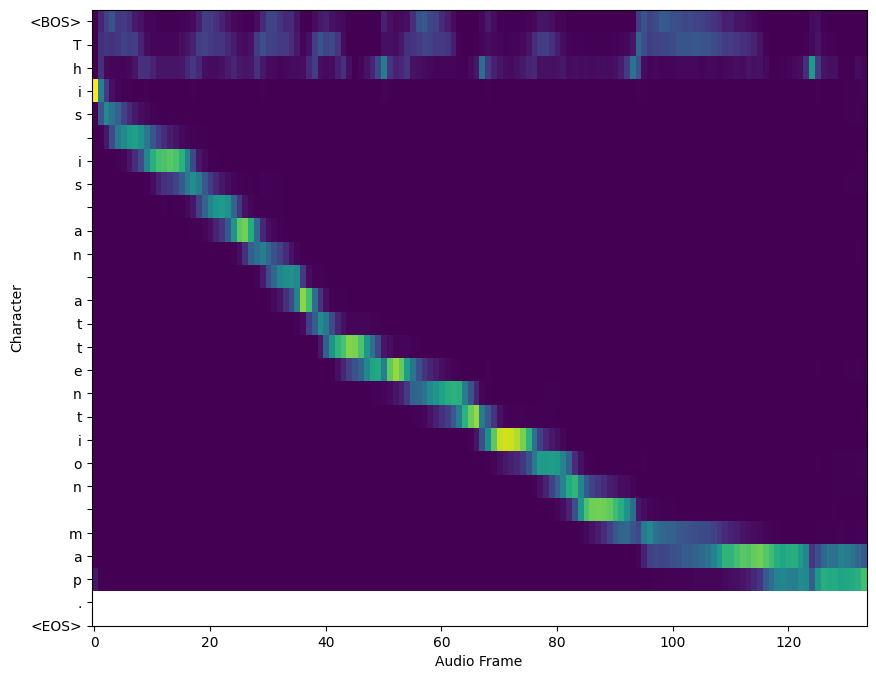

In [ ]:
# Pretrained Tacotron 2 uses grapheme input with beginning-of-speech and end-of-speech tokens
characters = ["<BOS>"] + [char for char in text] + ["<EOS>"]

fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel("Audio Frame")
plt.ylabel("Character")
_ = ax.imshow(alignment.transpose(), origin='upper', aspect='auto')
_ = ax.set_yticks(range(len(characters)))
_ = ax.set_yticklabels(characters)

In [ ]:
### YOUR TASK: test the attention mechanism on a longer sentence
# (e.g. on one of your earlier examples)

Testing Attention Mechanism on Longer Sentence

Text: "mister Johnson is turning thirty five years old on april fifteenth twenty twenty three."



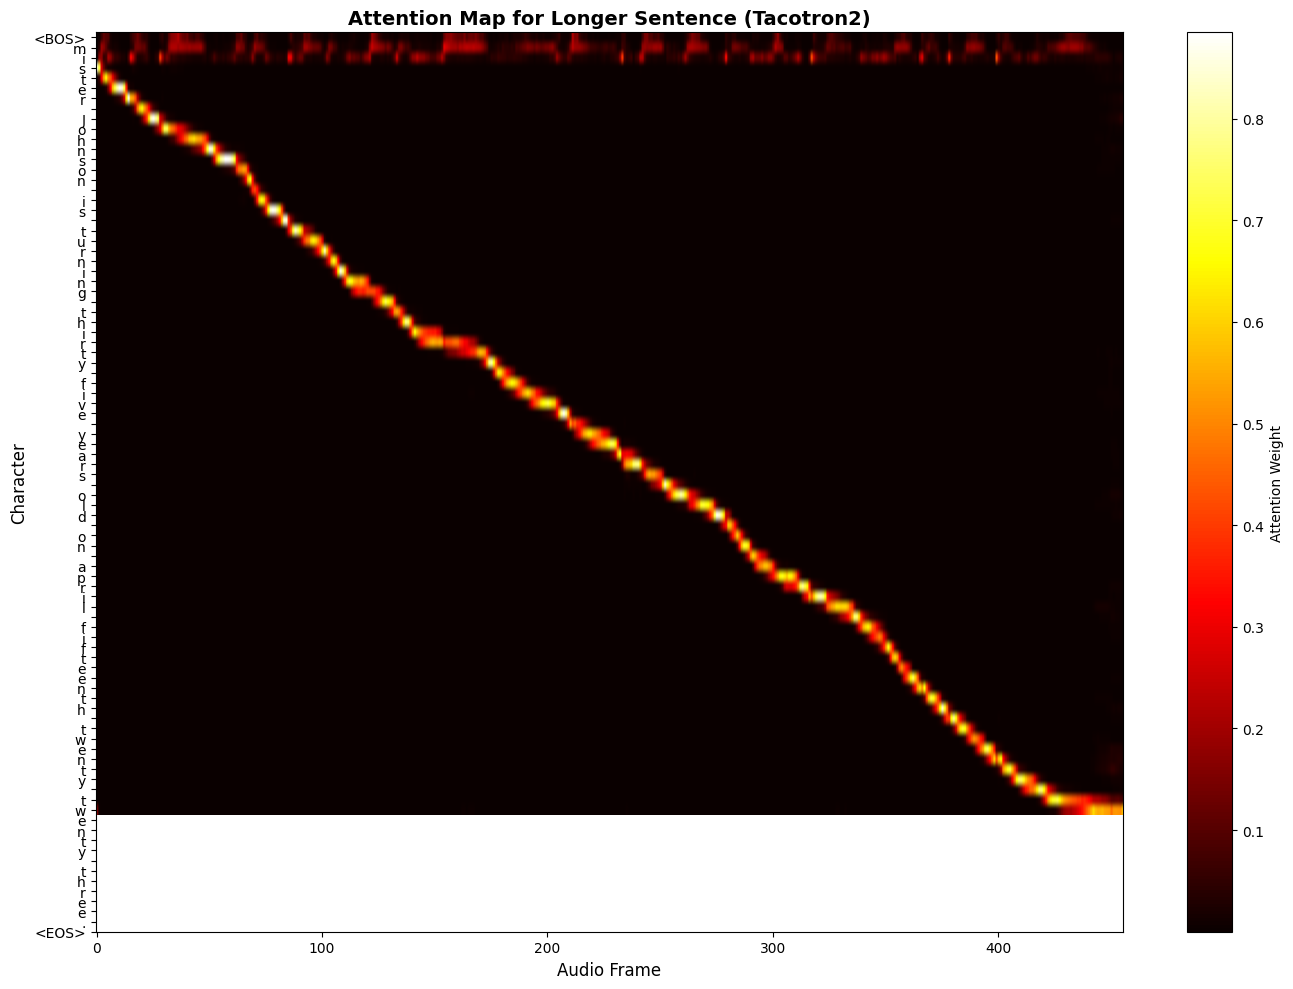

Attention Analysis

Observations:
1. The attention should be monotonically increasing (moving forward)
2. Each character should be attended to in sequence
3. The model 'reads' the text character by character
4. Some characters may have longer attention spans (e.g., vowels, longer sounds)
5. The attention map shows how the decoder aligns with the encoder output

Key Features:
• Bright areas indicate high attention weights
• The diagonal pattern shows proper alignment
• Smooth transitions indicate good model training


In [ ]:
# Test the attention mechanism on a longer sentence
# Using the normalized sentence from Section 5.1 (Text Normalization)
longer_text = "mister Johnson is turning thirty five years old on april fifteenth twenty twenty three."

print("=" * 70)
print("Testing Attention Mechanism on Longer Sentence")
print("=" * 70)
print(f"\nText: \"{longer_text}\"\n")

# Parse the text and get tokens
tokens_longer = tacotron2_model.parse(longer_text, normalize=True)
token_len_longer = torch.tensor([tokens_longer.shape[1]], dtype=torch.long, device=tacotron2_model.device)

# Generate attention alignments
_, _, _, alignments_longer, _ = tacotron2_model.forward(tokens=tokens_longer, token_len=token_len_longer)
alignment_longer = alignments_longer[0].cpu().detach().numpy()

# Prepare characters for visualization (add BOS and EOS tokens)
characters_longer = ["<BOS>"] + [char for char in longer_text] + ["<EOS>"]

# Visualize the attention map
fig, ax = plt.subplots(figsize=(14, 10))
plt.xlabel("Audio Frame", fontsize=12)
plt.ylabel("Character", fontsize=12)
plt.title("Attention Map for Longer Sentence (Tacotron2)", fontsize=14, fontweight='bold')

# Display the attention alignment
im = ax.imshow(alignment_longer.transpose(), origin='upper', aspect='auto', cmap='hot')
ax.set_yticks(range(len(characters_longer)))
ax.set_yticklabels(characters_longer, fontsize=10)
plt.colorbar(im, ax=ax, label="Attention Weight")

plt.tight_layout()
plt.show()

# Analysis
print("=" * 70)
print("Attention Analysis")
print("=" * 70)
print("\nObservations:")
print("1. The attention should be monotonically increasing (moving forward)")
print("2. Each character should be attended to in sequence")
print("3. The model 'reads' the text character by character")
print("4. Some characters may have longer attention spans (e.g., vowels, longer sounds)")
print("5. The attention map shows how the decoder aligns with the encoder output")
print("\nKey Features:")
print("• Bright areas indicate high attention weights")
print("• The diagonal pattern shows proper alignment")
print("• Smooth transitions indicate good model training")

COMPARISON: Tacotron2 vs FastPitch

Test sentence: "The quick brown fox jumps over the lazy dog."

1. Tacotron2 + HiFiGAN
Audio generated with Tacotron2 + HiFiGAN:



2. FastPitch + HiFiGAN
Audio generated with FastPitch + HiFiGAN:



3. Spectrogram Comparison


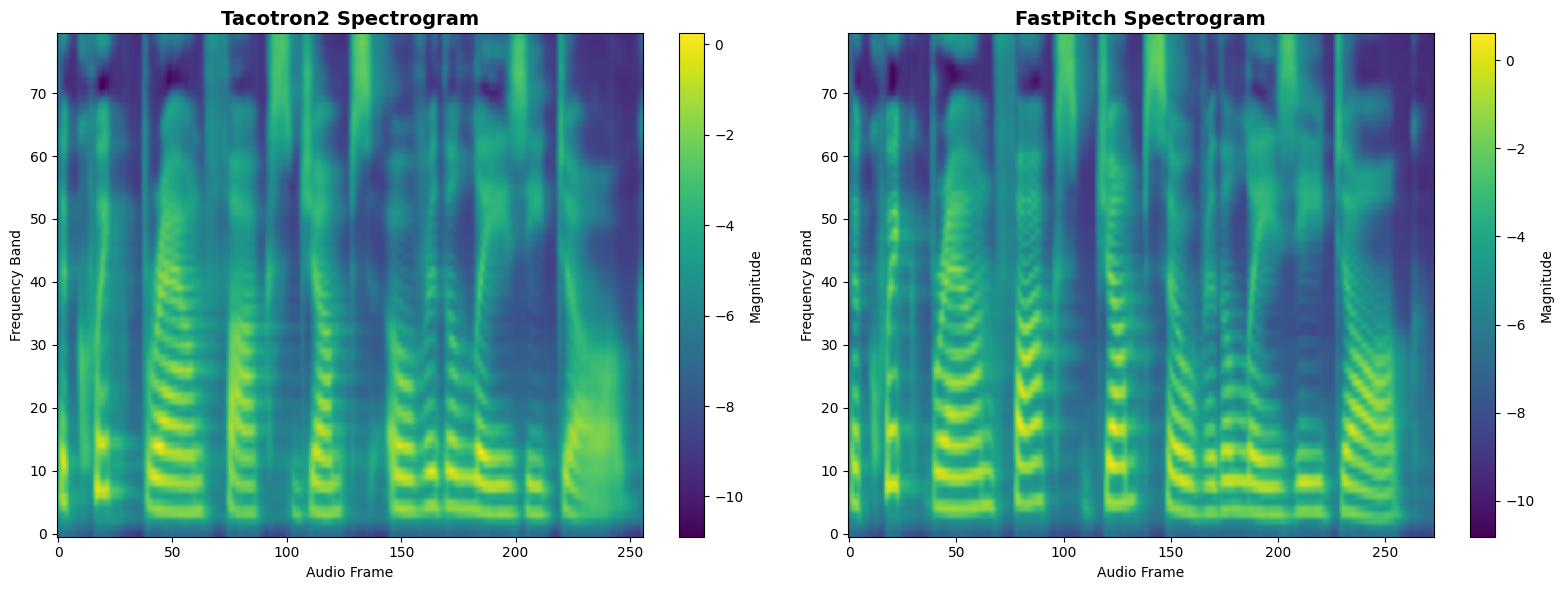


4. Key Differences

AUDIO QUALITY:
  • Tacotron2: Auto-regressive model, may have slight variations
  • FastPitch: Parallel model, more consistent and faster

SPECTROGRAM CHARACTERISTICS:
  • Tacotron2: Generated frame-by-frame, may show attention patterns
  • FastPitch: Generated in parallel, smoother temporal structure

INFERENCE SPEED:
  • Tacotron2: Slower (sequential generation)
  • FastPitch: Much faster (parallel generation, up to 100x faster)

CONTROL:
  • Tacotron2: Limited control over prosody
  • FastPitch: Can control pitch and duration per character/word


In [ ]:
# Use a single sentence for comparison
comparison_text = "The quick brown fox jumps over the lazy dog."

print("=" * 70)
print("COMPARISON: Tacotron2 vs FastPitch")
print("=" * 70)
print(f"\nTest sentence: \"{comparison_text}\"\n")

# ============================================
# 1. Tacotron2 + HiFiGAN
# ============================================
print("=" * 70)
print("1. Tacotron2 + HiFiGAN")
print("=" * 70)

# Parse text and generate spectrogram with Tacotron2
tokens_tacotron2 = spectrogram_model.parse(comparison_text, normalize=True)
spectrogram_tacotron2 = spectrogram_model.generate_spectrogram(tokens=tokens_tacotron2)

# Convert spectrogram to audio with HiFiGAN
audio_tacotron2 = vocoder.convert_spectrogram_to_audio(spec=spectrogram_tacotron2)

# Convert to numpy
spectrogram_tacotron2_np = spectrogram_tacotron2.cpu().detach().numpy()[0]
audio_tacotron2_np = audio_tacotron2.cpu().detach().numpy()[0]

print("Audio generated with Tacotron2 + HiFiGAN:")
ipd.display(ipd.Audio(audio_tacotron2_np, rate=22050))

# ============================================
# 2. FastPitch + HiFiGAN
# ============================================
print("\n" + "=" * 70)
print("2. FastPitch + HiFiGAN")
print("=" * 70)

# Parse text and generate spectrogram with FastPitch
tokens_fastpitch = fastpitch_model.parse(comparison_text, normalize=True)
spectrogram_fastpitch = fastpitch_model.generate_spectrogram(tokens=tokens_fastpitch)

# Convert spectrogram to audio with HiFiGAN (same vocoder)
audio_fastpitch = vocoder.convert_spectrogram_to_audio(spec=spectrogram_fastpitch)

# Convert to numpy
spectrogram_fastpitch_np = spectrogram_fastpitch.cpu().detach().numpy()[0]
audio_fastpitch_np = audio_fastpitch.cpu().detach().numpy()[0]

print("Audio generated with FastPitch + HiFiGAN:")
ipd.display(ipd.Audio(audio_fastpitch_np, rate=22050))

# ============================================
# 3. Visualize Spectrograms
# ============================================
print("\n" + "=" * 70)
print("3. Spectrogram Comparison")
print("=" * 70)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Tacotron2 spectrogram
im1 = axes[0].imshow(spectrogram_tacotron2_np, origin="lower", aspect="auto")
axes[0].set_title("Tacotron2 Spectrogram", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Audio Frame")
axes[0].set_ylabel("Frequency Band")
plt.colorbar(im1, ax=axes[0], label="Magnitude")

# Plot FastPitch spectrogram
im2 = axes[1].imshow(spectrogram_fastpitch_np, origin="lower", aspect="auto")
axes[1].set_title("FastPitch Spectrogram", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Audio Frame")
axes[1].set_ylabel("Frequency Band")
plt.colorbar(im2, ax=axes[1], label="Magnitude")

plt.tight_layout()
plt.show()

# ============================================
# 4. Observations and Differences
# ============================================
print("\n" + "=" * 70)
print("4. Key Differences")
print("=" * 70)
print("\nAUDIO QUALITY:")
print("  • Tacotron2: Auto-regressive model, may have slight variations")
print("  • FastPitch: Parallel model, more consistent and faster")
print("\nSPECTROGRAM CHARACTERISTICS:")
print("  • Tacotron2: Generated frame-by-frame, may show attention patterns")
print("  • FastPitch: Generated in parallel, smoother temporal structure")
print("\nINFERENCE SPEED:")
print("  • Tacotron2: Slower (sequential generation)")
print("  • FastPitch: Much faster (parallel generation, up to 100x faster)")
print("\nCONTROL:")
print("  • Tacotron2: Limited control over prosody")
print("  • FastPitch: Can control pitch and duration per character/word")

In order to get good quality output, we need our model's attention to follow these constraints:

*   The decoder should pay attention to one character at a time (sometimes it also places weight on the one character immediately before and/or after it).
*   The attention should be **monotonically increasing**, meaning it never go backwards in the text sequence. So the attention should only ever stay on the current character, or move forward to the next character.
*   The model should start on the first character in the sequence and end on the last character.

These constraints result in the decoder effectively "reading" the text character by character or word by word, similar to how humans read aloud.

A model may need to be trained for a while before its attention learns to follow these constraints. Before that, the attention may look non-sensical, and the model output will sound unintelligible.

Once the models learns the above constraints and starts producing well-behaved attention maps, it is said that the model has **aligned**.

## 7.8&nbsp;Parallel Models


There are some significant weaknesses to auto-regressive systems. Most notably:

*  Spectrograms are long (100s-1000s of frames), so generating them one frame at a time makes inference slow.
*  They are typically implemented using RNN based architectures, which are slow to train.
*  The user has little control over how the sentence is spoken.

Using duration prediction enables us to remove the auto-regressive inference and predict every spectrogram frame in parallel. This makes the inference speed up to 100x faster, making it highly preferable for deploying and serving to users.

### 7.8.1&nbsp;FastPitch

In NeMo we support [FastPitch](https://fastpitch.github.io/), a parallel transformer-based model with pitch and duration control and prediction.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/fastpitch_diagram.png" width="600", height="500"/>
</div>

At a high level it contains:

1.   An encoder consisting of a **feed-forward transformer block (FFTr)**, which transforms the input character embeddings into character pronunciation embeddings.
2.   A temporal CNN which takes the encoder output and predicts the duration and pitch of each character. At training time, the ground truth pitch and duration information are fed to the model (similar to teacher forcing).
3.   Each encoder output is repeated a number of times equal to the predicted duration. The repeated encoder output is the same length as the final spectrogram. For example, for characters 'abc' and predicted durations (2, 3, 1) we get the encoder output repeated 'aabbbc'.
4.   A decoder consisting of a FFTr that transforms this encoder output into the predicted spectrogram.

Some advantages to this approach are:

*   The duration prediction makes the output consistent and robust.
*   The model inference is fast, able to synthesize up to 1000 seconds of audio every second on an A100 GPU.
*   You can customize the prosody by manually selecting the pitch and duration of each character or word.

Let's run the same inference for FastPitch that we did with Tacotron2. The main difference is loading the FastPitch checkpoint using the `FastPitchModel` class.

In [ ]:
# this step is a bit slow, might take a few minutes

from nemo.collections.tts.models import FastPitchModel

fastpitch_model = FastPitchModel.from_pretrained("tts_en_fastpitch").eval().to(device)

[NeMo I 2025-12-14 18:41:07 cloud:58] Found existing object /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2025-12-14 18:41:07 cloud:64] Re-using file from: /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2025-12-14 18:41:07 common:947] Instantiating model from pre-trained checkpoint


[NeMo E 2025-12-14 18:41:08 base:45] `nemo_text_processing` not installed, see https://github.com/NVIDIA/NeMo-text-processing for more details.
[NeMo E 2025-12-14 18:41:08 base:48] The normalizer will be disabled.
[NeMo W 2025-12-14 18:41:08 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-12-14 18:41:08 modelPT:188] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_ty

[NeMo I 2025-12-14 18:41:08 features:306] PADDING: 1
[NeMo I 2025-12-14 18:41:08 save_restore_connector:284] Model FastPitchModel was successfully restored from /Users/liangwenlong/.cache/torch/NeMo/NeMo_2.6.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.


In [ ]:
text = "This audio was generated with the fastpitch text-to-speech model."

# Normalize the text and convert it into individual phonemes/tokens.
tokens = fastpitch_model.parse(text, normalize=True)

# Generate spectrogram from text
spectrogram = fastpitch_model.generate_spectrogram(tokens=tokens)

# Invert the spectrogram into audio samples
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

# Convert output from pytorch tensor to numpy array
spectrogram = spectrogram.cpu().detach().numpy()[0]
audio = audio.cpu().detach().numpy()[0]

In [ ]:
print(f'"{text}"\n')

ipd.Audio(audio, rate=22050)

"This audio was generated with the fastpitch text-to-speech model."



In [ ]:
### YOUR TASK: use a single sentence, and synthesize by two models: listen to the audio, and plot the spectrograms!
# - Tacotron2 + HiFiGAN
# - FastPitch + HiFiGAN
# what are the differences that you can hear or see?

COMPARISON: Tacotron2 vs FastPitch

Test sentence: "The quick brown fox jumps over the lazy dog."

1. Tacotron2 + HiFiGAN
Audio generated with Tacotron2 + HiFiGAN:



2. FastPitch + HiFiGAN
Audio generated with FastPitch + HiFiGAN:



3. Spectrogram Comparison


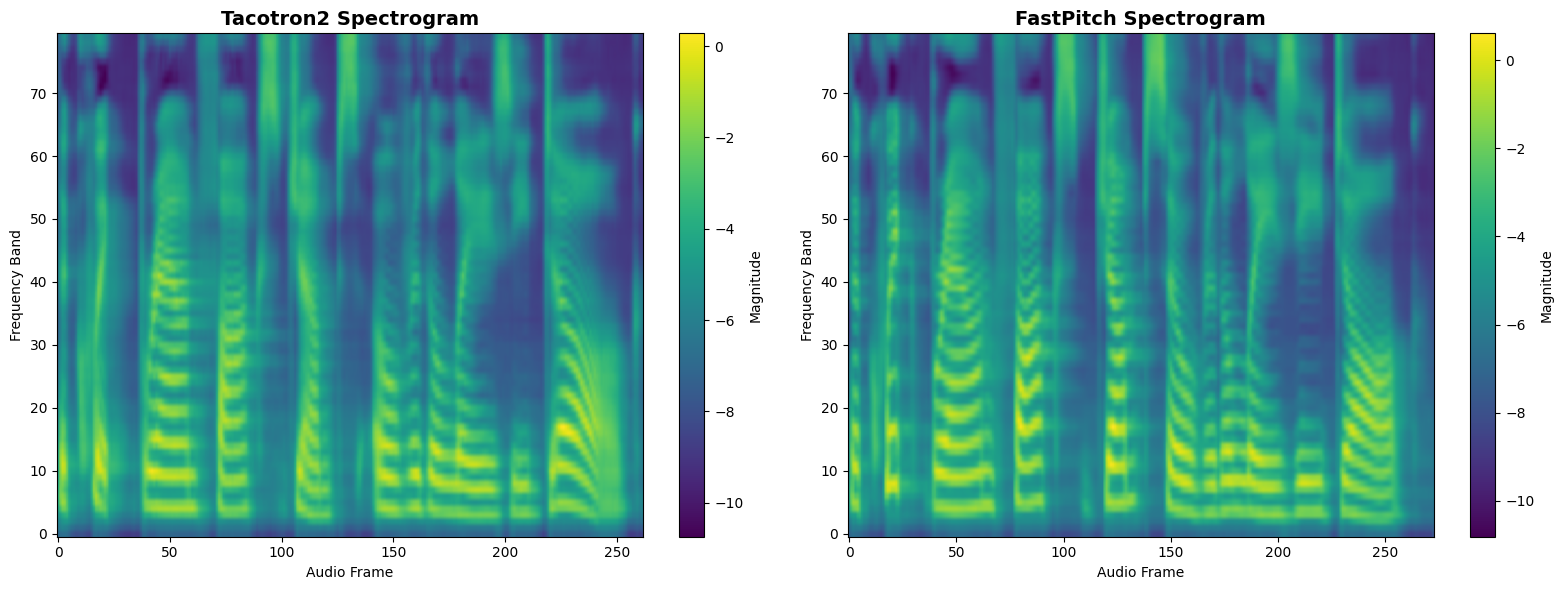


4. Key Differences

AUDIO QUALITY:
  • Tacotron2: Auto-regressive model, may have slight variations
  • FastPitch: Parallel model, more consistent and faster

SPECTROGRAM CHARACTERISTICS:
  • Tacotron2: Generated frame-by-frame, may show attention patterns
  • FastPitch: Generated in parallel, smoother temporal structure

INFERENCE SPEED:
  • Tacotron2: Slower (sequential generation)
  • FastPitch: Much faster (parallel generation, up to 100x faster)

CONTROL:
  • Tacotron2: Limited control over prosody
  • FastPitch: Can control pitch and duration per character/word


In [ ]:
### YOUR SOLUTION
# Use a single sentence for comparison
comparison_text = "The quick brown fox jumps over the lazy dog."

print("=" * 70)
print("COMPARISON: Tacotron2 vs FastPitch")
print("=" * 70)
print(f"\nTest sentence: \"{comparison_text}\"\n")

# ============================================
# 1. Tacotron2 + HiFiGAN
# ============================================
print("=" * 70)
print("1. Tacotron2 + HiFiGAN")
print("=" * 70)

# Parse text and generate spectrogram with Tacotron2
tokens_tacotron2 = spectrogram_model.parse(comparison_text, normalize=True)
spectrogram_tacotron2 = spectrogram_model.generate_spectrogram(tokens=tokens_tacotron2)

# Convert spectrogram to audio with HiFiGAN
audio_tacotron2 = vocoder.convert_spectrogram_to_audio(spec=spectrogram_tacotron2)

# Convert to numpy
spectrogram_tacotron2_np = spectrogram_tacotron2.cpu().detach().numpy()[0]
audio_tacotron2_np = audio_tacotron2.cpu().detach().numpy()[0]

print("Audio generated with Tacotron2 + HiFiGAN:")
ipd.display(ipd.Audio(audio_tacotron2_np, rate=22050))

# ============================================
# 2. FastPitch + HiFiGAN
# ============================================
print("\n" + "=" * 70)
print("2. FastPitch + HiFiGAN")
print("=" * 70)

# Parse text and generate spectrogram with FastPitch
tokens_fastpitch = fastpitch_model.parse(comparison_text, normalize=True)
spectrogram_fastpitch = fastpitch_model.generate_spectrogram(tokens=tokens_fastpitch)

# Convert spectrogram to audio with HiFiGAN (same vocoder)
audio_fastpitch = vocoder.convert_spectrogram_to_audio(spec=spectrogram_fastpitch)

# Convert to numpy
spectrogram_fastpitch_np = spectrogram_fastpitch.cpu().detach().numpy()[0]
audio_fastpitch_np = audio_fastpitch.cpu().detach().numpy()[0]

print("Audio generated with FastPitch + HiFiGAN:")
ipd.display(ipd.Audio(audio_fastpitch_np, rate=22050))

# ============================================
# 3. Visualize Spectrograms
# ============================================
print("\n" + "=" * 70)
print("3. Spectrogram Comparison")
print("=" * 70)

# Create side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Tacotron2 spectrogram
im1 = axes[0].imshow(spectrogram_tacotron2_np, origin="lower", aspect="auto")
axes[0].set_title("Tacotron2 Spectrogram", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Audio Frame")
axes[0].set_ylabel("Frequency Band")
plt.colorbar(im1, ax=axes[0], label="Magnitude")

# Plot FastPitch spectrogram
im2 = axes[1].imshow(spectrogram_fastpitch_np, origin="lower", aspect="auto")
axes[1].set_title("FastPitch Spectrogram", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Audio Frame")
axes[1].set_ylabel("Frequency Band")
plt.colorbar(im2, ax=axes[1], label="Magnitude")

plt.tight_layout()
plt.show()

# ============================================
# 4. Observations and Differences
# ============================================
print("\n" + "=" * 70)
print("4. Key Differences")
print("=" * 70)
print("\nAUDIO QUALITY:")
print("  • Tacotron2: Auto-regressive model, may have slight variations")
print("  • FastPitch: Parallel model, more consistent and faster")
print("\nSPECTROGRAM CHARACTERISTICS:")
print("  • Tacotron2: Generated frame-by-frame, may show attention patterns")
print("  • FastPitch: Generated in parallel, smoother temporal structure")
print("\nINFERENCE SPEED:")
print("  • Tacotron2: Slower (sequential generation)")
print("  • FastPitch: Much faster (parallel generation, up to 100x faster)")
print("\nCONTROL:")
print("  • Tacotron2: Limited control over prosody")
print("  • FastPitch: Can control pitch and duration per character/word")

# 9.&nbsp;Model Evaluation

There are no well-established objective metrics for evaluating how good a TTS model is. Rather, quality is usually based on human opinion or perception, commonly measured through surveys.

The most common type of survey for evaluating TTS quality is [mean opinion score](https://en.wikipedia.org/wiki/Mean_opinion_score) (**MOS**), in which listeners rate the quality of TTS samples on a 1 to 5 scale.

Another common alternative is [MUSHRA](https://en.wikipedia.org/wiki/MUSHRA) in which users are provided a reference (the ground truth audio) and asked to rate several TTS samples relative to the reference.

There are some metrics which are occasionally used to try and measure audio quality such as [MCD-DTW](https://github.com/MattShannon/mcd), [PESQ](https://en.wikipedia.org/wiki/Perceptual_Evaluation_of_Speech_Quality), and [STOI](https://torchmetrics.readthedocs.io/en/stable/audio/short_time_objective_intelligibility.html). But these have very limited accuracy and usefulness.

The lack of objective numerical metrics that can be trained on is a large reason as to why many state of the art models rely on GAN based training to get good quality.

In [ ]:
### this is the end of the DL practice first part, related to Text-to-Speech

# 10.&nbsp;Additional Resources

To learn more about what TTS technology and models are available in NeMo, please look through our [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/tts/intro.html#).

To get more hands on experience with NeMo TTS, look through some of our other [tutorials](https://github.com/NVIDIA/NeMo/tree/stable/tutorials/tts).

*   Running pretrained models: [Inference_ModelSelect](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/Inference_ModelSelect.ipynb)
*   FastPitch [training](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/FastPitch_MixerTTS_Training.ipynb) and [fine-tuning](https://github.com/NVIDIA/NeMo/blob/stable/tutorials/tts/FastPitch_Finetuning.ipynb)

To learn how to deploy and serve your TTS models, visit [Riva](https://docs.nvidia.com/deeplearning/riva/index.html).

# 11.&nbsp;References

1.   [Speech Processing Primer](https://aman.ai/primers/ai/speech-processing/)
2.   [TTS Survey](https://arxiv.org/abs/2106.15561)
3.   [Tacotron 2](https://google.github.io/tacotron/publications/tacotron2/index.html)
4.   [Non-Attentive Tacotron](https://arxiv.org/abs/2010.04301)
5.   [FastPitch](https://fastpitch.github.io/)
6.   [RAD-TTS](https://nv-adlr.github.io/RADTTS)
7.   [VITS](https://arxiv.org/pdf/2106.06103.pdf)
8.   [One TTS Alignment To Rule Them All](https://arxiv.org/abs/2108.10447)
9.   [Parallel Models](https://arxiv.org/abs/2202.13066)
10.   [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)
11.   [HiFi-GAN](https://arxiv.org/abs/2010.05646)
12.   [WaveRNN](https://arxiv.org/abs/1802.08435)
13.   [PyTorch](https://pytorch.org/docs/stable/index.html)
14.   [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict)